## **Boosting Classification Metrics with Advanced Machine Learning Techniques**

## **Data card**

- #### **User ID**: Serves as an identifier for each user
- #### **Group**: Contains both the control group (A) and treatment group (B)
- #### **Page Views**: Number of pages the user viewed during their session
- #### **Time Spent**: The total amount of time, in seconds, that the user spent on the site during the session
- #### **Conversion**: Indicates whether a user has completed a desired action (Yes/No)
- #### **Device**: Type of device used to access the website
- #### **Location**: The country in UK where the user is based in

## **Import packages and load data**

In [1]:
import kagglehub, os
import pandas as pd

# Download the dataset
path = kagglehub.dataset_download("adarsh0806/ab-testing-practice")

# List files in the folder
files = os.listdir(path)
csv_file = os.path.join(path, files[0])  
data = pd.read_csv(csv_file)
data

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland
...,...,...,...,...,...,...,...
4995,16360,B,12,313,No,Mobile,Wales
4996,18084,B,10,313,No,Desktop,Northern Ireland
4997,12063,A,11,156,No,Desktop,England
4998,18647,B,13,346,No,Desktop,Wales


## **Initial Data Observation**

In [2]:
print("Data Shape:", data.shape)
print("\n")
print(data.info())
print("\n")
missing_values = data.isnull().sum()
print("Missing value")
print(missing_values)
print("\n")
has_duplicates = data.duplicated().any()  
print("Are there duplicate entries?：", has_duplicates)

for col in data.columns:
    print(f"\nColumn: {col}")
    print("Unique values:", data[col].unique())
    print("Count of unique values:", data[col].nunique())


Data Shape: (5000, 7)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB
None


Missing value
User ID       0
Group         0
Page Views    0
Time Spent    0
Conversion    0
Device        0
Location      0
dtype: int64


Are there duplicate entries?： False

Column: User ID
Unique values: [14292 11682 19825 ... 12063 18647 16686]
Count of unique values: 5000

Column: Group
Unique values: ['B' 'A']
Count of unique values: 2

Column: Page Views
Unique values: [ 3  9  2  4  1  5  8 12 14  6  7 11 13 10]
Count of unique values: 14

<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Next, we take a look at the target variable.</b>
</h4>

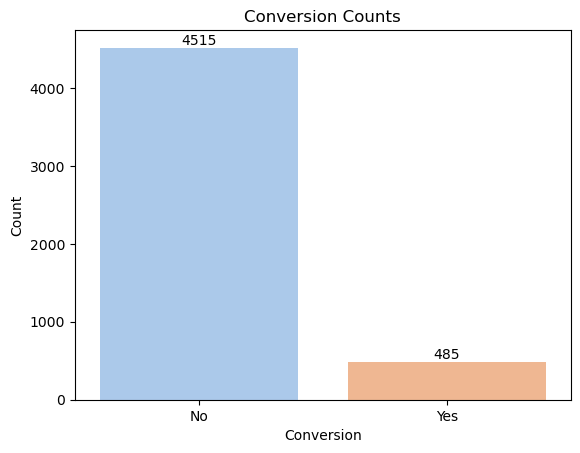

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

counts = data['Conversion'].value_counts()

sns.barplot(x=counts.index, y=counts.values, palette='pastel')
plt.xlabel('Conversion')
plt.ylabel('Count')
plt.title('Conversion Counts')

for i, v in enumerate(counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')  

plt.show()


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>After performing a basic data observation, we will build a classification model to predict conversions. First, we will remove the columns that are not relevant for the prediction process.</b>
</h4>

In [4]:
# Remove the columns that will not be utilized in the prediction process.
data = data.drop(columns=["User ID", "Group"])
data

,Page Views,Time Spent,Conversion,Device,Location
0,3,424,No,Mobile,Northern Ireland
1,9,342,No,Mobile,Scotland
2,2,396,No,Desktop,Northern Ireland
3,4,318,No,Desktop,Wales
4,1,338,Yes,Desktop,Scotland
...,...,...,...,...,...
4995,12,313,No,Mobile,Wales
4996,10,313,No,Desktop,Northern Ireland
4997,11,156,No,Desktop,England
4998,13,346,No,Desktop,Wales


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Because the target variable is imbalanced, we sample from the majority class to achieve a balanced dataset.</b>
</h4>

In [5]:
df_yes = data[data['Conversion'] == 'Yes']
df_no = data[data['Conversion'] == 'No']

df_yes_sampled = df_yes.sample(n=485, replace=True, random_state=42)
df_no_sampled = df_no.sample(n=485, replace=False, random_state=42)

data = pd.concat([df_yes_sampled, df_no_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
data


,Page Views,Time Spent,Conversion,Device,Location
0,12,271,No,Desktop,England
1,9,87,Yes,Mobile,England
2,5,404,Yes,Desktop,England
3,14,159,No,Desktop,Wales
4,3,442,Yes,Mobile,Northern Ireland
...,...,...,...,...,...
965,3,189,Yes,Mobile,England
966,9,348,Yes,Mobile,Scotland
967,9,287,No,Desktop,England
968,8,420,Yes,Desktop,England


## **Data Pre-Processing**

<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Categorical(Nominal): Categories with no specific order</b>
</h4>

In [6]:
# Categorical(Nominal): Categories with no specific order
# Perform one-hot encoding on categorical columns 
encoded = pd.get_dummies(data[['Device', 'Location']], prefix=['Device', 'Location'])

# Convert the encoded columns to integers
encoded = encoded.astype(int)

# Drop the original categorical columns and concatenate the new encoded columns to the data
data = pd.concat([data.drop(['Device', 'Location'], axis=1), encoded], axis=1)
data

,Page Views,Time Spent,Conversion,Device_Desktop,Device_Mobile,Location_England,Location_Northern Ireland,Location_Scotland,Location_Wales
0,12,271,No,1,0,1,0,0,0
1,9,87,Yes,0,1,1,0,0,0
2,5,404,Yes,1,0,1,0,0,0
3,14,159,No,1,0,0,0,0,1
4,3,442,Yes,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
965,3,189,Yes,0,1,1,0,0,0
966,9,348,Yes,0,1,0,0,1,0
967,9,287,No,1,0,1,0,0,0
968,8,420,Yes,1,0,1,0,0,0


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Categorical(Ordinal): Categories with a defined order</b>
</h4>

In [7]:
# Categorical(Ordinal): Categories with a defined order
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['Page Views'] = label_encoder.fit_transform(data['Page Views'])
data

,Page Views,Time Spent,Conversion,Device_Desktop,Device_Mobile,Location_England,Location_Northern Ireland,Location_Scotland,Location_Wales
0,11,271,No,1,0,1,0,0,0
1,8,87,Yes,0,1,1,0,0,0
2,4,404,Yes,1,0,1,0,0,0
3,13,159,No,1,0,0,0,0,1
4,2,442,Yes,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
965,2,189,Yes,0,1,1,0,0,0
966,8,348,Yes,0,1,0,0,1,0
967,8,287,No,1,0,1,0,0,0
968,7,420,Yes,1,0,1,0,0,0


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Continuous Data: Numeric values with continuous range</b>
</h4>

In [8]:
# Continuous Data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data['Time Spent'] = scaler.fit_transform(data[['Time Spent']])
data

,Page Views,Time Spent,Conversion,Device_Desktop,Device_Mobile,Location_England,Location_Northern Ireland,Location_Scotland,Location_Wales
0,11,0.311696,No,1,0,1,0,0,0
1,8,-1.265116,Yes,0,1,1,0,0,0
2,4,1.451457,Yes,1,0,1,0,0,0
3,13,-0.648103,No,1,0,0,0,0,1
4,2,1.777104,Yes,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
965,2,-0.391014,Yes,0,1,1,0,0,0
966,8,0.971558,Yes,0,1,0,0,1,0
967,8,0.448810,No,1,0,1,0,0,0
968,7,1.588572,Yes,1,0,1,0,0,0


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Splitting the data into training and testing sets</b>
</h4>

In [9]:
# Splitting the data into training and testing sets
X = data.drop("Conversion", axis=1)
y = data["Conversion"].map({"No": 0, "Yes": 1})

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Building Classification Models and Model Evaluation**

<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Logistic Regression</b>
</h4>

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

lr_model = LogisticRegression(max_iter=1000)  
lr_model.fit(X_train, y_train)


y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_lr))


Accuracy: 0.4896907216494845
Precision: 0.4777777777777778
Recall: 0.45263157894736844
F1 Score: 0.4648648648648649
ROC AUC: 0.5675704412546517


## **Insight**

- The Logistic Regression model shows **weak performance**.  

- Almost all metrics (Accuracy, Precision, Recall, F1 Score) are **close to random levels**.  

- The ROC AUC is only **0.57**, indicating that the model has **limited classification ability**.


## **Enhance classification model performance**

<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>First, we use Random Forest along with GridSearchCV to improve the performance of the classification model.</b>
</h4>

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.6649484536082474
Precision: 0.6415094339622641
Recall: 0.7157894736842105
F1 Score: 0.6766169154228856
ROC AUC: 0.7155768208399788


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Next, we incorporate interaction features and re-run the Random Forest model.</b>
</h4>

In [12]:
# Add interaction features
data['PageViews_TimeSpent'] = data['Page Views'] * data['Time Spent']
data['TimeSpent_per_Page'] = data['Time Spent'] / (data['Page Views'] + 1e-5)  
data

# Splitting the data into training and testing sets
X = data.drop("Conversion", axis=1)
y = data["Conversion"].map({"No": 0, "Yes": 1})

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Re-run Random Forest along with GridSearchCV to improve the performance of the classification model.</b>
</h4>

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  
}


rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.654639175257732
Precision: 0.6372549019607843
Recall: 0.6842105263157895
F1 Score: 0.6598984771573604
ROC AUC: 0.7505050505050506


<h4 style="font-size:18px; line-height:1.5; padding:5px;">
<b>Finally, we apply stacking by using Random Forest, Decision Tree, and Logistic Regression as base learners, and Logistic Regression as the meta-learner.</b>
</h4>

In [14]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('lr_base', LogisticRegression(max_iter=1000))
]

meta_learner = LogisticRegression(max_iter=1000)

stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)


stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)
y_pred_proba = stack_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.6907216494845361
Precision: 0.6842105263157895
Recall: 0.6842105263157895
F1 Score: 0.6842105263157895
ROC AUC: 0.756193514088251


## **Insight**

- The model shows **moderate performance**.  
- Accuracy, Precision, Recall, and F1 Score are around **68%**, indicating balanced predictions.  
- ROC AUC is **0.76**, showing good ability to distinguish between classs.



## **Summary**

- The Logistic Regression model shows **weak performance**:  
  Accuracy, Precision, Recall, and F1 Score near random (~49%), ROC AUC 0.57.  

- After optimization using Random Forest / stacking / feature engineering, the model shows **improved performance**:  
  Accuracy, Precision, Recall, and F1 Score around **68%**, ROC AUC **0.76**, indicating better discrimination between classes.
